In [1]:
# to do's:
# drop waste water discharge
# drop demographic index (it is a product of low income and minority)
# maybe drop 70,000 population size and 2000 cancer rate (puerto rico)

## Imports and Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# imputation
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

In [2]:
def clean_col(col_name):
    '''
    Rename columns to be more Pythonic:
    - lowercase
    - underscore between words
    - replace some language with more descriptive examples
    
    Return revised column name.
    '''
    col_name = col_name.lower()
    col_name = col_name.replace('pct','_pct')
    col_name = col_name.replace('state','st')
    col_name = col_name.replace('acstot','')
    col_name = col_name.replace('minor','poc')
    col_name = col_name.replace('less','sub_')
    col_name = col_name.replace('lowinc','low_inc')
    col_name = col_name.replace('ling','ling_')
    col_name = col_name.replace('under5','under_5')
    col_name = col_name.replace('over64','over_64')
    col_name = col_name.replace('vuleo_pct','dem_index')
    col_name = col_name.replace('pre1960','pre_1960')
    col_name = col_name.replace('ptraf','traffic_prox')
    col_name = col_name.replace('dslpm','diesel_pm')
    col_name = col_name.replace('pnpl','npl_prox')
    col_name = col_name.replace('prmp','rmp_prox')
    col_name = col_name.replace('ptsdf','waste_prox')
    col_name = col_name.replace('resp','resp_index')
    col_name = col_name.replace('pwdis','waste_water')
    col_name = col_name.replace('25','_25')
    col_name = col_name.replace('ust','undgrd_stor')
    
    return col_name

---
## Basic Cleaning

In [3]:
raw_data = pd.read_csv('../data/EJSCREEN_2021_StatePctile_Tracts.csv')

C:\Users\John\AppData\Local\Temp\ipykernel_10596\1401447621.py:1: DtypeWarning: Columns (128,129,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('../data/EJSCREEN_2021_StatePctile_Tracts.csv')


Columns beginning with `B_` and `T_` provide information for creating specialized images. This is not necessary for our exploratory data analysis so we will drop these columns. Columns beginning with `P_` and `D_` contain percentile and index data. These can be reconstructed from other columns without much difficulty, so we will drop these as well.

There is also identification and shape data that we do not need for eda. These columns are located in the first two and last two columns. We will drop these columns, too.

In [4]:
# initial columns of interest
# cut columns related to image data, clean the rest
init_cols = [col for col in raw_data.columns if col[:2] not in 'P_B_T_D_']

# drop OBJECTID - repeated index col
# drop Shape cols
init_cols = init_cols[2:-2]
init_cols

['STATE_NAME',
 'ST_ABBREV',
 'REGION',
 'ACSTOTPOP',
 'MINORPCT',
 'LOWINCPCT',
 'LESSHSPCT',
 'LINGISOPCT',
 'UNDER5PCT',
 'OVER64PCT',
 'UNEMPPCT',
 'VULEOPCT',
 'PRE1960PCT',
 'DSLPM',
 'CANCER',
 'RESP',
 'PTRAF',
 'PWDIS',
 'PNPL',
 'PRMP',
 'PTSDF',
 'OZONE',
 'PM25',
 'UST']

Below we change the column labels to lower case and include an underscore to between the `PCT` (representing percent) to make the columns a bit more readable.

In [5]:
env = raw_data[init_cols].copy()
env.columns = [clean_col(col) for col in env.columns]

To check the results, we list out the revised column names.

In [6]:
env.columns

Index(['st_name', 'st_abbrev', 'region', 'pop', 'poc_pct', 'low_inc_pct',
       'sub_hs_pct', 'ling_iso_pct', 'under_5_pct', 'over_64_pct', 'unemp_pct',
       'dem_index', 'pre_1960_pct', 'diesel_pm', 'cancer', 'resp_index',
       'traffic_prox', 'waste_water', 'npl_prox', 'rmp_prox', 'waste_prox',
       'ozone', 'pm_25', 'undgrd_stor'],
      dtype='object')

There are few hundred rows of data where the numeric entries consist entirely of zeros or missing values. These rows will be impossible to work with and should be removed.

In [7]:
# drop rows containing no information (consisting of ALL zeros and nulls)

# identify location of first and last numeric columns
pop_index = env.columns.get_loc('pop')
stor_index = env.columns.get_loc('undgrd_stor')

# count nulls within a row
nulls_in_row = env.iloc[:,pop_index:stor_index+1].isnull().sum(axis = 1)
# count zeros within a row
zeros_in_row = (env.iloc[:,pop_index:stor_index+1] == 0).sum(axis = 1)

# if zeros and nulls sum to number of numeric columns, drop the row
total_num_cols = env.iloc[:,pop_index:stor_index+1].shape[1]
env.drop(index = env[nulls_in_row + zeros_in_row == total_num_cols].index, inplace = True)

One of our major goals is to predict the air toxics cancer risk given by the `cancer` column. Since this column is especially valuable to us, we want to avoid imputing missing values within it. Below we see it contains 246 missing values.

In [8]:
env.isnull().sum()

st_name             0
st_abbrev           0
region              0
pop                 0
poc_pct             0
low_inc_pct         0
sub_hs_pct          0
ling_iso_pct        0
under_5_pct         0
over_64_pct         0
unemp_pct           0
dem_index           0
pre_1960_pct        0
diesel_pm         246
cancer            246
resp_index        246
traffic_prox     2343
waste_water     19644
npl_prox            0
rmp_prox            0
waste_prox          0
ozone            1383
pm_25            1383
undgrd_stor         0
dtype: int64

Before we drop the rows missing `cancer` data, we check to see if the entries seem genuinely random and that we are not introducing any blatant bias to our dataset. Since the states of these entries seem reasonably distributed, it feels fair to assume they are random.

In [9]:
env.loc[env['cancer'].isna(), 'st_name'].value_counts()

New York          31
Florida           26
California        18
Texas             16
Michigan          13
Virginia          12
Louisiana         12
North Carolina    10
Tennessee          8
Colorado           7
Pennsylvania       7
Georgia            7
Nevada             7
South Carolina     6
Illinois           6
Arizona            6
Massachusetts      5
Kentucky           5
Mississippi        4
Maryland           4
Kansas             4
New Hampshire      3
Utah               3
Ohio               3
Oregon             3
Washington         3
Wisconsin          3
New Jersey         2
Iowa               2
Missouri           2
Vermont            1
Alabama            1
New Mexico         1
Minnesota          1
Indiana            1
Delaware           1
Connecticut        1
Wyoming            1
Name: st_name, dtype: int64

In [10]:
env.dropna(subset = ['cancer'], inplace = True)

Conveniently, dropping the rows with missing `cancer` values coincided with rows missing `diesel_pm` and `resp_index`.

In [11]:
env.isnull().sum()

st_name             0
st_abbrev           0
region              0
pop                 0
poc_pct             0
low_inc_pct         0
sub_hs_pct          0
ling_iso_pct        0
under_5_pct         0
over_64_pct         0
unemp_pct           0
dem_index           0
pre_1960_pct        0
diesel_pm           0
cancer              0
resp_index          0
traffic_prox     2103
waste_water     19401
npl_prox            0
rmp_prox            0
waste_prox          0
ozone            1383
pm_25            1383
undgrd_stor         0
dtype: int64

Another thing to be cautious of is that several columns are based on percentages of the population. These percentages can be somewhat deceptive for rows containing lower populations. For example, 100% of the population being minority feels more meaningful when the population size is 2416 than if the population size is 8. For this reason we want to filter out rows with especially small population sizes.

Additionally, each row represents a Census tract. Census tracts generally have a population size above 1,200. Rows with a population size below 1,200 correspond to tribal data. We do not want to eliminate the tribal data, especially with the history of environmental injustice towards indigenous people. For this reason, we will set a population size of 30 as a lower bound for the data. This way, we can feel more confident in interpreting percentages and still keep as much of the tribal data as possible.

Below we verify that the data corresponding to population sizes below 30 is reasonably distributed across all states.

In [12]:
env.loc[env['pop'] < 30, 'st_name'].value_counts()

New York          34
Florida           19
California        18
Texas             15
Pennsylvania      15
Puerto Rico       10
Virginia          10
Tennessee          9
Hawaii             8
Kansas             6
Michigan           6
North Carolina     5
Massachusetts      4
Missouri           4
Louisiana          4
Arizona            4
Ohio               3
Alabama            3
Kentucky           3
Maryland           2
New Jersey         2
Indiana            2
Georgia            2
Rhode Island       1
Washington         1
Arkansas           1
South Carolina     1
Montana            1
Idaho              1
Nebraska           1
Oklahoma           1
Alaska             1
Illinois           1
Nevada             1
Oregon             1
Name: st_name, dtype: int64

---

## Imputing

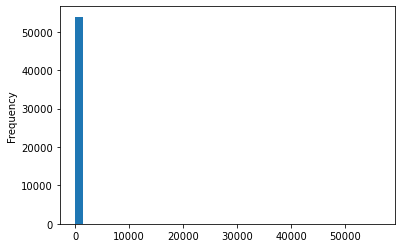

In [13]:
env['waste_water'].plot.hist(bins= 40);

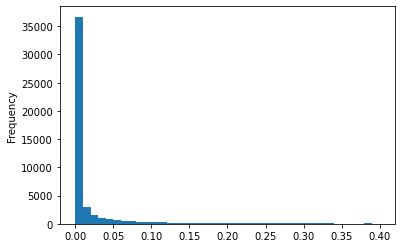

In [14]:
env.loc[env['waste_water'] < 0.4, 'waste_water'].plot.hist(bins= 40);

In [15]:
env[env['waste_water'] > 30_000].T

,11389,23188
st_name,California,Illinois
st_abbrev,CA,IL
region,9,5
pop,2387,4502
poc_pct,0.906577,0.443803
low_inc_pct,0.383032,0.410702
sub_hs_pct,0.376526,0.292536
ling_iso_pct,0.212644,0.103542
under_5_pct,0.060327,0.060418
over_64_pct,0.147047,0.117725


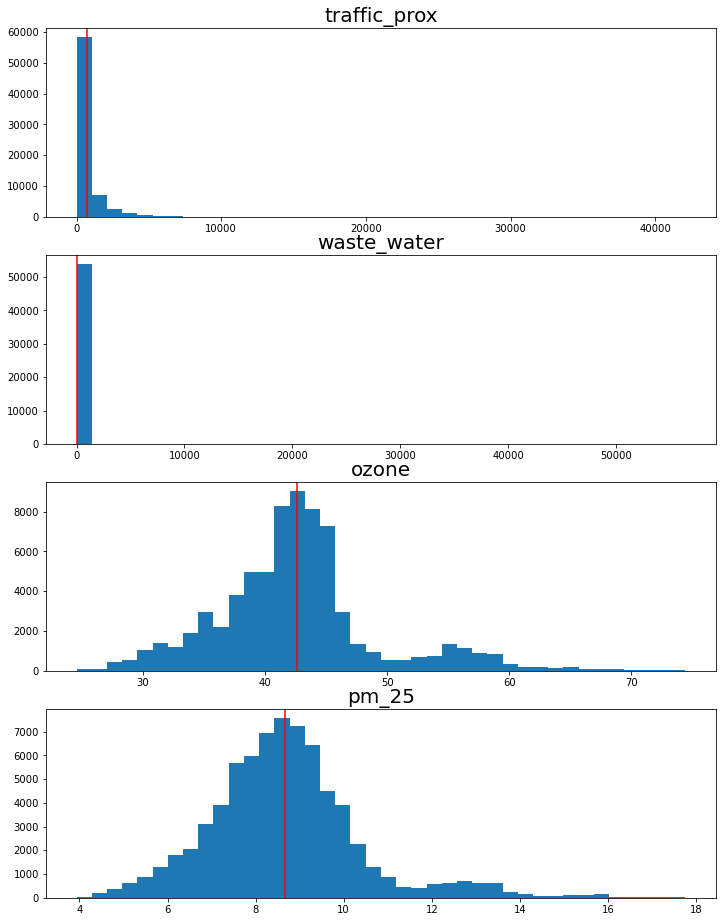

In [16]:
cols_to_impute = ['traffic_prox', 'waste_water', 'ozone', 'pm_25']

plt.figure(figsize = (12,16))

for i in range(4):
    plt.subplot(4,1,i+1)
    col_name = cols_to_impute[i]
    plt.title(f'{col_name}', size = 20)
    plt.hist(env[col_name], bins = 40)
    plt.axvline(env[col_name].mean(), color = 'red')

In [17]:
# may want to one-hot-encode region to impute using regression 
X = env.drop(columns = ['cancer', 'st_name', 'st_abbrev'])
y = env['cancer']

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(X,y, test_size = 0.2, random_state = 13)

In [19]:
it = IterativeImputer(estimator = LinearRegression())
X_train_missing = it.fit_transform(X_train)
X_val_missing = it.transform(X_val)

X_train_imputed = pd.DataFrame(X_train_missing, columns = it.get_feature_names_out())
X_val_imputed = pd.DataFrame(X_val_missing, columns = it.get_feature_names_out())

In [20]:
X_imputed = pd.concat([X_train_imputed, X_val_imputed])

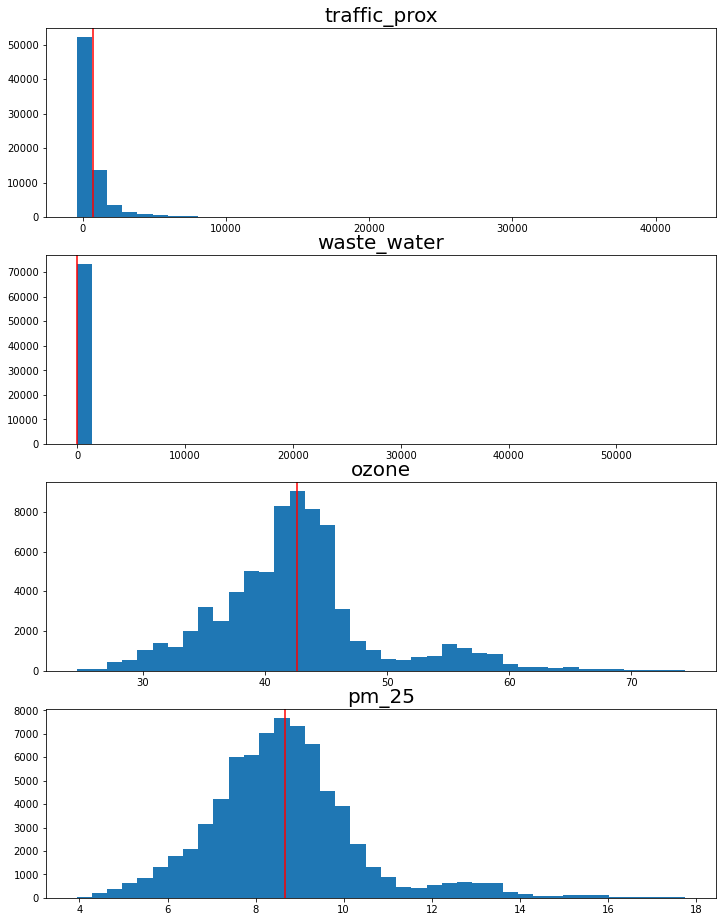

In [21]:
cols_to_impute = ['traffic_prox', 'waste_water', 'ozone', 'pm_25']

plt.figure(figsize = (12,16))

for i in range(4):
    plt.subplot(4,1,i+1)
    col_name = cols_to_impute[i]
    plt.title(f'{col_name}', size = 20)
    plt.hist(X_imputed[col_name], bins = 40)
    plt.axvline(X_imputed[col_name].mean(), color = 'red')
    

---

## For the Team

Below is code showing that if we drop the null values outside of `waste_water`, we eliminate Puerto Rico, Hawaii, and Alaska from the entire dataset. These three territories seem to only be missing `ozone` and `pm_25` data.

In [22]:
# collect rows where there are any missing values
# besides waste_water with 20,000 missing values

# na_rows are the incdices of null values
# has_na is the dataset containing null
na_rows = env.select_dtypes(include = 'number').drop(columns = ['waste_water']).isna().any(axis = 1)
has_na = env[na_rows]

In [23]:
# 10 states with the most null values in the dataset currently
null_states = has_na['st_abbrev'].value_counts().head(10).index
has_na['st_abbrev'].value_counts().head(10)

PR    895
HI    321
AK    167
KY    122
TX    122
MI    118
NC    106
OH     86
NY     81
ME     79
Name: st_abbrev, dtype: int64

In [24]:
# the total number of appearances of these states in the entire dataset
env['st_abbrev'].value_counts()[null_states]

PR     895
HI     321
AK     167
KY    1110
TX    5238
MI    2756
NC    2174
OH    2943
NY    4870
ME     351
Name: st_abbrev, dtype: int64

Another thing to note about these three groups is that their nulls are primarily located in in the `ozone` and `pm_25` columns.

In [25]:
for territory in ['PR', 'HI', 'AK']:
    print(territory)
    print(env[env['st_abbrev'] == territory].isnull().sum(), '\n\n')

PR
st_name           0
st_abbrev         0
region            0
pop               0
poc_pct           0
low_inc_pct       0
sub_hs_pct        0
ling_iso_pct      0
under_5_pct       0
over_64_pct       0
unemp_pct         0
dem_index         0
pre_1960_pct      0
diesel_pm         0
cancer            0
resp_index        0
traffic_prox      7
waste_water     120
npl_prox          0
rmp_prox          0
waste_prox        0
ozone           895
pm_25           895
undgrd_stor       0
dtype: int64 


HI
st_name           0
st_abbrev         0
region            0
pop               0
poc_pct           0
low_inc_pct       0
sub_hs_pct        0
ling_iso_pct      0
under_5_pct       0
over_64_pct       0
unemp_pct         0
dem_index         0
pre_1960_pct      0
diesel_pm         0
cancer            0
resp_index        0
traffic_prox     10
waste_water     120
npl_prox          0
rmp_prox          0
waste_prox        0
ozone           321
pm_25           321
undgrd_stor       0
dtype: int64 


AK